In [1]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

from os import listdir
from os.path import isfile, join
import random

In [2]:
train_set_size = 100

import sys
np.set_printoptions(threshold=sys.maxsize)

In [54]:
#generate homography pair

def generate_sample_pair(path, number_of_pairs):

    files = [f for f in listdir(path) if isfile(join(path, f))]

    for i in range(number_of_pairs):

        #izberemo naključno sliko
        image = cv2.imread(join(path, files[random.randint(0, len(files) - 1)]))

        #sliko prevzorčimo na izbrano velikost (320x240 pikslov) in pretvorimo v sivinsko
        image = cv2.resize(image, (320, 240))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        
        #v sliki izberemo okno velikost 64x64 na naključni lokaciji

        x = random.randint(30, 234)
        y = random.randint(30, 154)

        rect = np.array([[x, y], [x + 64, y], [x + 64, y + 64], [x, y + 64]])

        
        #4 kotičke okna pomaknemo za naključne pomike v intervalu [-16, 16]
        
        rect_prim = np.array([[rect[0][0] + random.randint(-16, 16), rect[0][1] + random.randint(-16, 16)], 
                     [rect[1][0] + random.randint(-16, 16), rect[1][1] + random.randint(-16, 16)], 
                     [rect[2][0] + random.randint(-16, 16), rect[2][1] + random.randint(-16, 16)], 
                     [rect[3][0] + random.randint(-16, 16), rect[3][1] + random.randint(-16, 16)]], np.int32)

        #iz 4 kotičkov in njihovih pomikov izračunamo homografijo H
        H, _ = cv2.findHomography(rect, rect_prim)

        #inverz ocenjene homografije H^-1 apliciramo na sliko, dobimo transformirano sliko
        warped_image = cv2.warpPerspective(image, H, (image.shape[1], image.shape[0]))

        # rect_prim = rect_prim.reshape((-1, 1, 2))

        # cv2.rectangle(image, rect[0], rect[2], (255, 0, 0), 2)
        # cv2.polylines(image, [rect_prim], True, (0, 0, 255), 2)
        
        # plt.imshow(image)
        # plt.show()

        # cv2.rectangle(warped_image, rect[0], rect[2], (255, 0, 0), 2)

        # plt.imshow(warped_image)
        # plt.show()

        #iz slike in transformirane slike izrežemo vzorca z izbranim oknom

        sample_original = image[y:y + 64, x:x + 64]
        sample_transformed = warped_image[y:y + 64, x:x + 64]

    return image, warped_image, sample_original, sample_transformed, rect, rect_prim
    

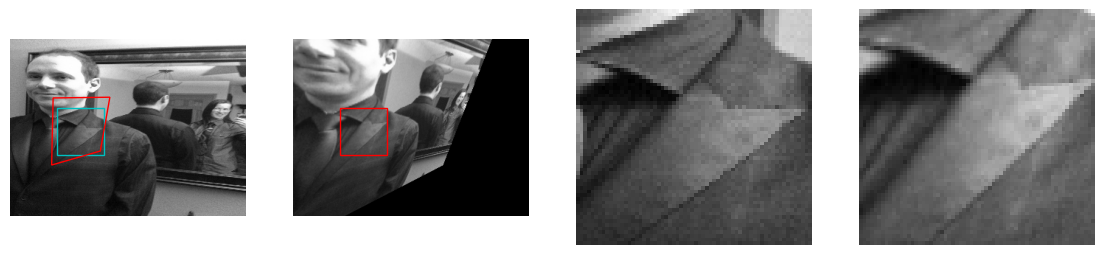

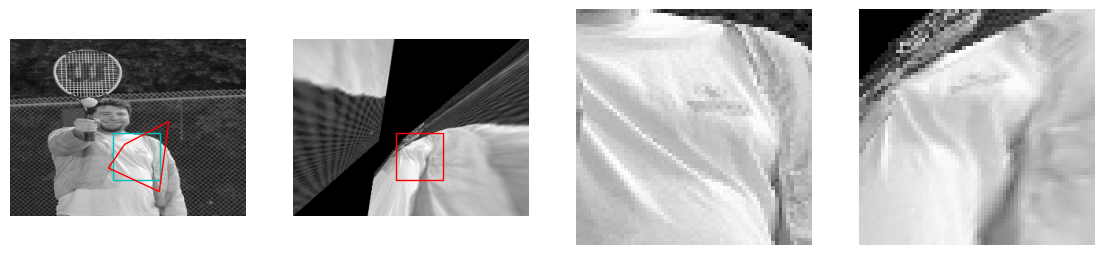

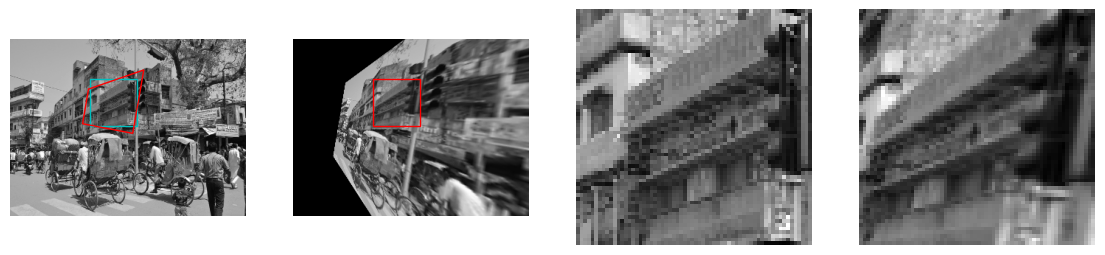

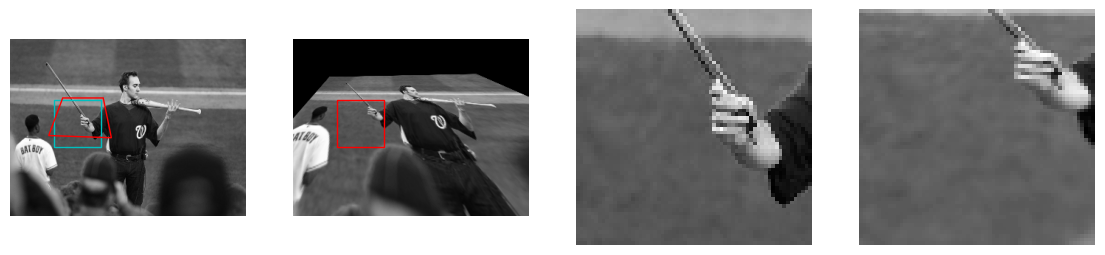

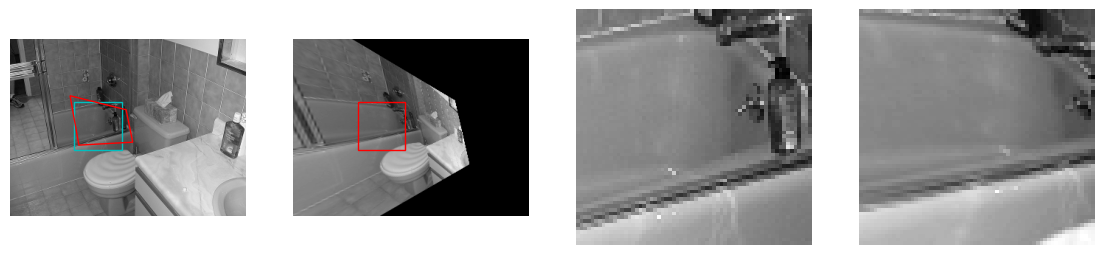

In [55]:
if __name__ == "__main__":

    number_of_pairs = 5 #change to 100

    for i in range(number_of_pairs):

        image_original, image_transformed, sample_original, sample_transformed, rect_original, rect_transformed = generate_sample_pair("unlabeled2017/unlabeled2017", number_of_pairs)
    
        fig, ax = plt.subplots(1, 4, figsize=(14, 5))
        ax[0].imshow(image_original, cmap='gray')
        ax[0].add_patch(plt.Polygon(rect_original, fill=False, ec='c', lw=1.0))
        ax[0].add_patch(plt.Polygon(rect_transformed, fill=False, ec='r', lw=1.0))
        ax[0].set_axis_off()
    
        ax[1].imshow(image_transformed, cmap='gray')
        ax[1].add_patch(plt.Polygon(rect_original, fill=False, ec='r', lw=1.0))
        ax[1].set_axis_off()
    
        ax[2].imshow(sample_original, cmap='gray')
        ax[2].set_axis_off()
    
        ax[3].imshow(sample_transformed, cmap='gray')
        ax[3].set_axis_off()
    